In [1]:
import os, sys
os.environ['CUDA_VISIBLE_DEVICES'] = "2,3"
import torch
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib as plt
from PIL import Image
sys.path.append('../src')
from utils import *
import seaborn as sns
from matplotlib.lines import Line2D
import cv2
import matplotlib as mpl
import scipy.stats as st
import math
import scipy.stats

/export/raid1/home/ojeda040/miniconda3/envs/SS_vd/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# folder   = "SCS VD PCA LR 10:250:5 0.6 Exp3 AE"
# log_path = "/export/raid1/home/kneel027/Second-Sight/logs/" + folder + "/statistics_df_10.csv"

# folder   = "SCS VD PCA LR 10:250:5 0.3 Exp2 AE"
# log_path = "/export/raid1/home/kneel027/Second-Sight/logs/" + folder + "/statistics_df_10.csv"

# folder   = "SCS VD PCA LR 10:250:5 0.4 Exp AE"
# log_path = "/export/raid1/home/kneel027/Second-Sight/logs/" + folder + "/statistics_df_57.csv"
# log_path = "/export/raid1/home/kneel027/Second-Sight/logs/" + folder + "/statistics_df_57_test.csv"
# #log_path = "/export/raid1/home/kneel027/Second-Sight/logs/" + folder + "/statistics_df_10.csv"

# folder   = "SCS VD PCA LR 10:250:5 0.6 Exp3 AE NA"
# log_path = "/export/raid1/home/kneel027/Second-Sight/logs/" + folder + "/statistics_df_54.csv"
# #log_path = "/export/raid1/home/kneel027/Second-Sight/logs/" + folder + "/statistics_df_10.csv"

folder   = "SCS UC 10:250:5 0.6 Exp3 AE Fixed copy"
log_path = "/export/raid1/home/kneel027/Second-Sight/logs/" + folder + "/statistics_df_60.csv"

df = pd.read_csv(log_path)
df.tail(80)

# Sample Indicator: 
    #   0 --> Ground Truth
    #   1 --> Ground Truth CLIP
    #   2 --> Decoded CLIP Only
    #   3 --> Library Reconstruction
    #   4 --> Search Reconstruction

,Unnamed: 0,ID,Iter,Sample Indicator,Strength,Brain Correlation V1,Brain Correlation V2,Brain Correlation V3,Brain Correlation V4,Brain Correlation Early Visual,Brain Correlation Higher Visual,Brain Correlation Unmasked,SSIM,Pixel Correlation,CLIP Pearson,CLIP Two-way
760,760,54,4.0,NaN,0.9616,0.818646,0.807189,0.876509,0.876826,0.834205,0.902443,0.871362,0.396000,0.167459,0.651036,0.999990
761,761,54,5.0,NaN,0.9250,0.808989,0.821652,0.838199,0.851925,0.824097,0.914512,0.868733,0.379930,0.268281,0.672681,0.999989
762,762,54,6.0,NaN,0.8704,0.802575,0.831224,0.876829,0.875395,0.838694,0.924804,0.881088,0.417457,0.304670,0.670509,1.000000
763,763,54,7.0,NaN,0.7942,0.835843,0.870329,0.911486,0.905816,0.869765,0.925735,0.895843,0.389915,0.247007,0.605588,1.000000
764,764,54,8.0,NaN,0.6928,0.873010,0.896629,0.916119,0.907492,0.890634,0.929319,0.908253,0.381918,0.214009,0.659778,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,835,59,9.0,4.0,0.5626,0.835681,0.826549,0.850817,0.853188,0.831735,0.939857,0.883236,0.143518,0.083098,0.455344,0.056805
836,836,59,NaN,3.0,NaN,0.623364,0.544786,0.708869,0.707249,0.623424,0.894517,0.761784,0.101453,-0.076868,0.652826,0.999990
837,837,59,NaN,2.0,NaN,0.521629,0.567376,0.681615,0.806545,0.592697,0.906236,0.755632,0.146487,-0.003112,0.657429,1.000000
838,838,59,NaN,1.0,NaN,0.050977,0.132621,0.177627,0.102051,0.104605,0.397611,0.205834,0.147510,0.489776,NaN,NaN


In [36]:
# Statistical Analysis

# ------------------------------------------ Quantitative Measures -----------------------------
#     Methods       |  PixCorr |  SSIM  |  CLIP |
#                   |          |        |       |          
#  Takagi et al.    |          |        | 77.0% |
#  Stable Diffusion |   .150   |  .325  |       |
#  Brain-Diffuser   |   .254   |  .356  | 91.5% |

# Final Sample Mean SSIM:  0.24619865488800002
# Final Sample Mean Pixel Correlation:  0.18779825951199997
# Final Sample Mean CLIP Pearson:  0.6848930502039999
# Final Sample Mean CLIP Two-way:  0.9188355520279999

print("------------------------------------------------ Search Reconstruction -----------------------------------------------------------------\n")

df_final_samples = df.loc[(df['Sample Indicator'] == 4.0)]

print("Final Sample Mean SSIM Search Reconstruction: ", df_final_samples['SSIM'].mean())

print("Final Sample Confidence Interval SSIM Search Reconstruction: ", ((df_final_samples['SSIM'].std() * 1.96) / math.sqrt(len(df_final_samples.index))))

print("Final Sample Mean Pixel Correlation Search Reconstruction: ", df_final_samples['Pixel Correlation'].mean())

print("Final Sample Confidence Interval Pixel Correlation Search Reconstruction: ", ((df_final_samples['Pixel Correlation'].std() * 1.96) / math.sqrt(len(df_final_samples.index))))

print("Final Sample Mean CLIP Pearson Search Reconstruction: ", df_final_samples['CLIP Pearson'].mean())

print("Final Sample Mean CLIP Two-way Search Reconstruction: ", df_final_samples['CLIP Two-way'].mean())

print("Final Sample Confidence Interval CLIP Two-way Decoded CLIP Only: ", ((df_final_samples['CLIP Two-way'].std() * 1.96) / math.sqrt(len(df_final_samples.index))))

print("------------------------------------------------ Library Reconstruction -----------------------------------------------------------------\n")

df_library_samples = df.loc[(df['Sample Indicator'] == 3.0)]

print("Final Sample Mean SSIM Library Reconstruction: ", df_library_samples['SSIM'].mean())

print("Final Sample Confidence Interval SSIM Search Reconstruction: ", ((df_library_samples['SSIM'].std() * 1.96) / math.sqrt(len(df_library_samples.index))))

print("Final Sample Mean Pixel Correlation Library Reconstruction: ", df_library_samples['Pixel Correlation'].mean())

print("Final Sample Confidence Interval Pixel Correlation Library Reconstruction: ", ((df_library_samples['Pixel Correlation'].std() * 1.96) / math.sqrt(len(df_library_samples.index))))

print("Final Sample Mean CLIP Pearson Library Reconstruction: ", df_library_samples['CLIP Pearson'].mean())

print("Final Sample Mean CLIP Two-way Library Reconstruction: ", df_library_samples['CLIP Two-way'].mean())

print("Final Sample Confidence Interval CLIP Two-way Library Reconstruction : ", ((df_library_samples['CLIP Two-way'].std() * 1.96) / math.sqrt(len(df_library_samples.index))))

print("------------------------------------------------ Decoded CLIP Only -----------------------------------------------------------------\n")

df_decoded_samples = df.loc[(df['Sample Indicator'] == 2.0)]

print("Final Sample Mean SSIM Decoded CLIP Only: ", df_decoded_samples['SSIM'].mean())

print("Final Sample Confidence Interval SSIM Decoded CLIP Only: ", ((df_decoded_samples['SSIM'].std() * 1.96) / math.sqrt(len(df_decoded_samples.index))))

print("Final Sample Mean Pixel Correlation Decoded CLIP Only: ", df_decoded_samples['Pixel Correlation'].mean())

print("Final Sample Confidence Interval Pixel Correlation Decoded CLIP Only: ", ((df_decoded_samples['Pixel Correlation'].std() * 1.96) / math.sqrt(len(df_decoded_samples.index))))

print("Final Sample Mean CLIP Pearson Decoded CLIP Only: ", df_decoded_samples['CLIP Pearson'].mean())

print("Final Sample Mean CLIP Two-way Decoded CLIP Only: ", df_decoded_samples['CLIP Two-way'].mean())

print("Final Sample Confidence Interval CLIP Two-way Decoded CLIP Only: ", ((df_decoded_samples['CLIP Two-way'].std() * 1.96) / math.sqrt(len(df_decoded_samples.index))))

------------------------------------------------ Search Reconstruction -----------------------------------------------------------------

Final Sample Mean SSIM Search Reconstruction:  0.29544236178666666
Final Sample Confidence Interval SSIM Search Reconstruction:  0.04183595028736526
Final Sample Mean Pixel Correlation Search Reconstruction:  0.21513766043166666
Final Sample Confidence Interval Pixel Correlation Search Reconstruction:  0.04054247918810143
Final Sample Mean CLIP Pearson Search Reconstruction:  0.6153001174366666
Final Sample Mean CLIP Two-way Search Reconstruction:  0.8268627698916667
Final Sample Confidence Interval CLIP Two-way Decoded CLIP Only:  0.0908334883642694
------------------------------------------------ Library Reconstruction -----------------------------------------------------------------

Final Sample Mean SSIM Library Reconstruction:  0.2772971657416667
Final Sample Confidence Interval SSIM Search Reconstruction:  0.043085533996029726
Final Sample Mea

     Unnamed: 0  ID  Iter  Sample Indicator  Strength  Brain Correlation V1  \
12           12   0   NaN               0.0    0.5626              0.908820   
25           25   1   NaN               0.0    0.5626              0.866193   
38           38   2   NaN               0.0    0.5626              0.936503   
51           51   3   NaN               0.0    0.5626              0.872334   
64           64   4   NaN               0.0    0.5626              0.887856   
77           77  25   NaN               0.0    0.5626              0.490988   
90           90  26   NaN               0.0    0.5626              0.804160   
103         103  27   NaN               0.0    0.5626              0.810127   
116         116  28   NaN               0.0    0.5626              0.739080   
129         129  29   NaN               0.0    0.5626              0.789306   

     Brain Correlation V2  Brain Correlation V3  Brain Correlation V4  \
12               0.874150              0.858289          

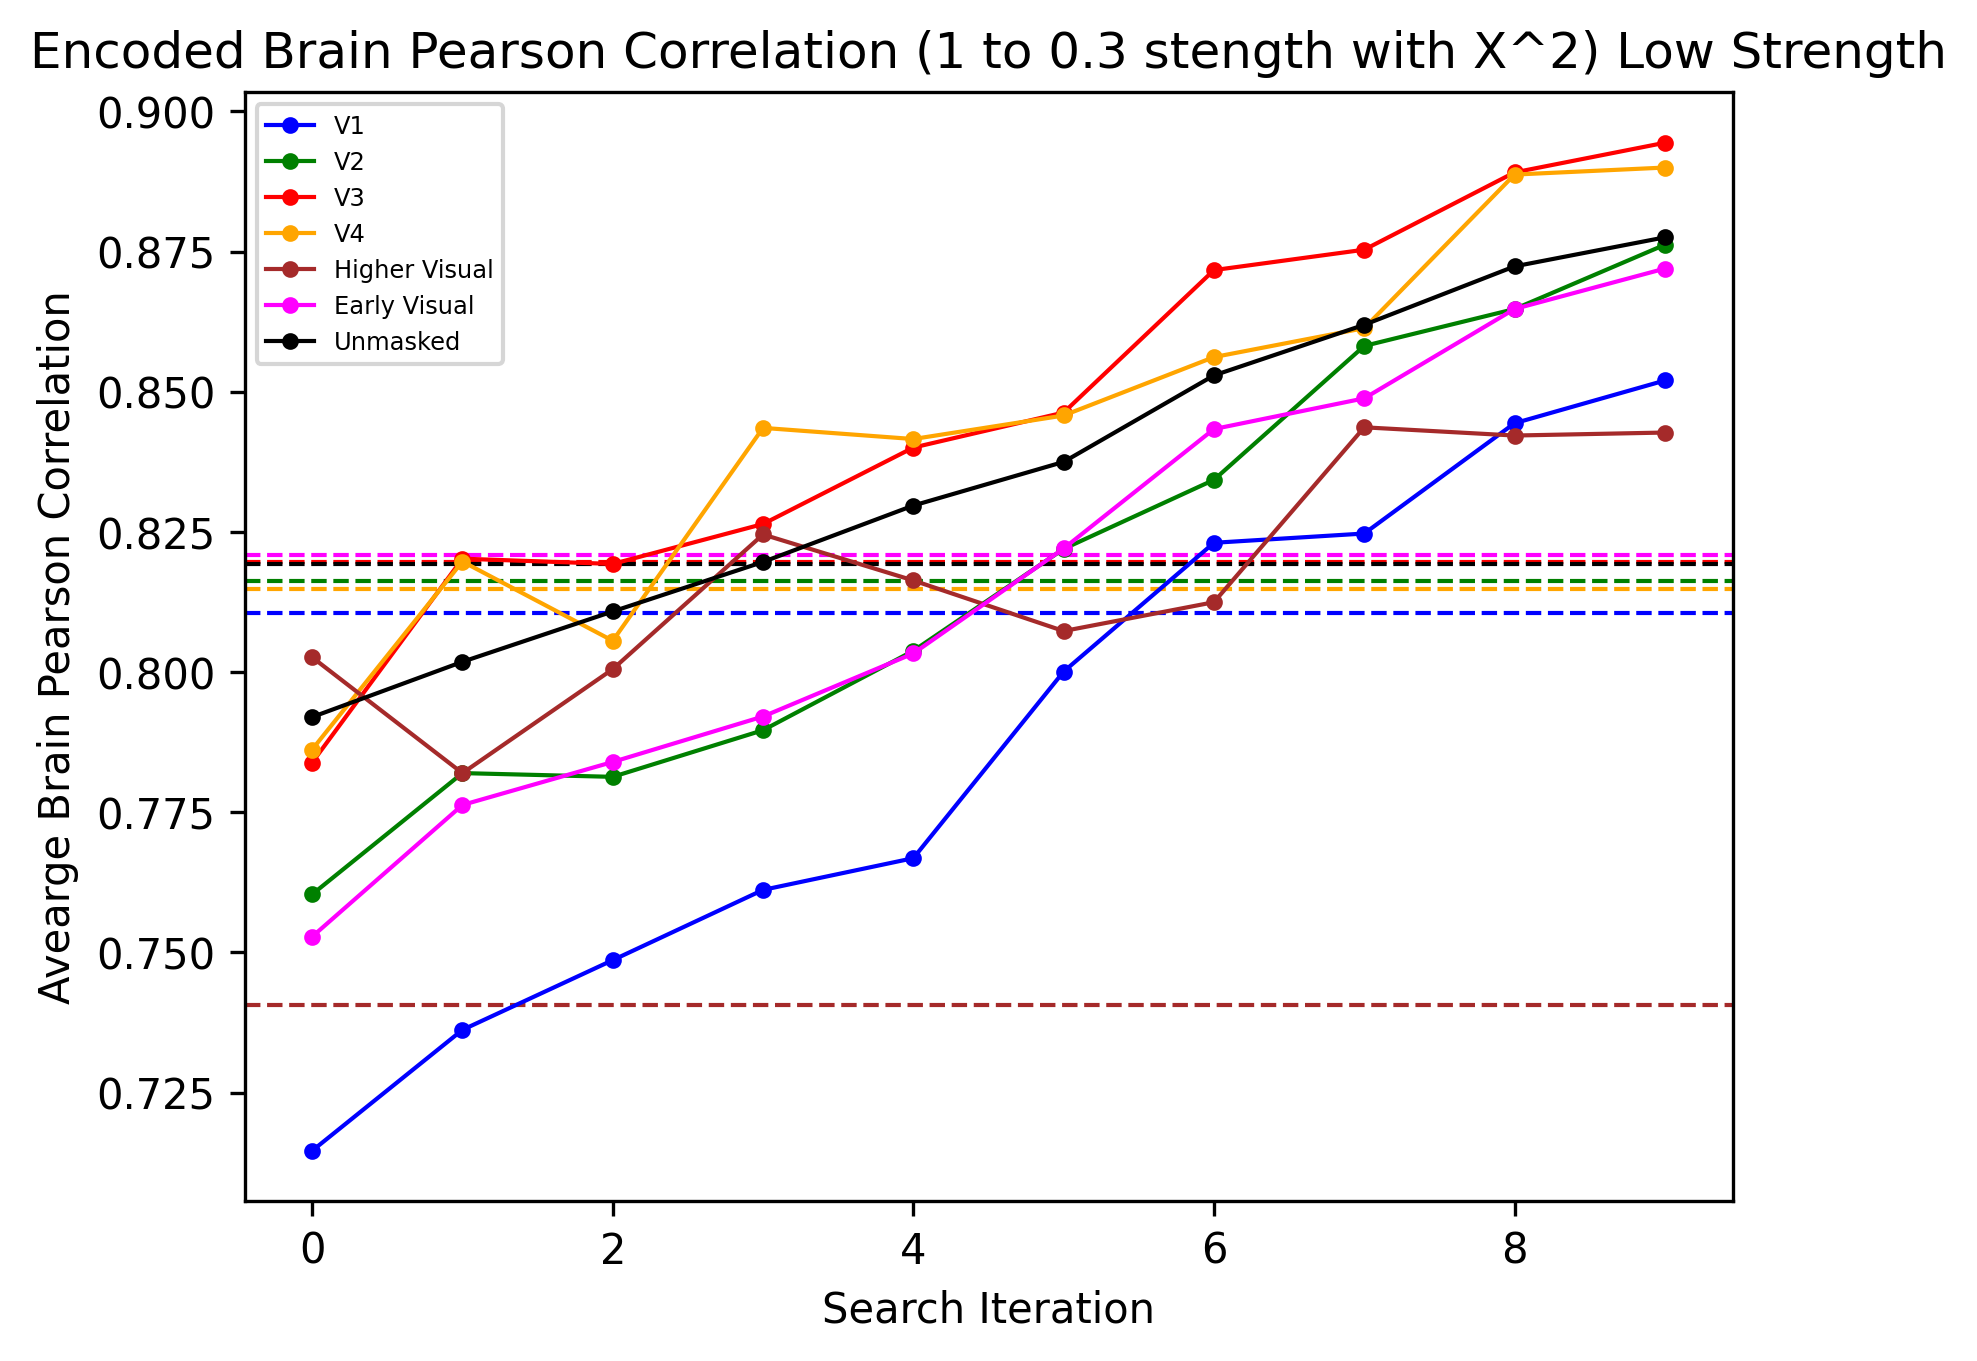

In [46]:
# Average Iteration Brain Region Plot
print(df.loc[(df['Sample Indicator'] == 0.0)])

brain_correlation_V1 = []
brain_correlation_V2 = []
brain_correlation_V3 = []
brain_correlation_V4 = []
brain_correlation_early_visual = []
brain_correlation_higher_visual = []
brain_correlation_unmasked = []
brain_correlation_ground_truth = []

for iteration in range(10):
    
    iteration_val_v1 = df.loc[(df['Iter'] == iteration)]['Brain Correlation V1'].mean()
    iteration_val_v2 = df.loc[(df['Iter'] == iteration)]['Brain Correlation V2'].mean()
    iteration_val_v3 = df.loc[(df['Iter'] == iteration)]['Brain Correlation V3'].mean()
    iteration_val_v4 = df.loc[(df['Iter'] == iteration)]['Brain Correlation V4'].mean()
    iteration_val_ev = df.loc[(df['Iter'] == iteration)]['Brain Correlation Early Visual'].mean()
    iteration_val_hv = df.loc[(df['Iter'] == iteration)]['Brain Correlation Higher Visual'].mean()
    iteration_val_unmasked = df.loc[(df['Iter'] == iteration)]['Brain Correlation Unmasked'].mean()
    
    brain_correlation_V1.append(iteration_val_v1)
    brain_correlation_V2.append(iteration_val_v2)
    brain_correlation_V3.append(iteration_val_v3)
    brain_correlation_V4.append(iteration_val_v4)
    brain_correlation_early_visual.append(iteration_val_ev)
    brain_correlation_higher_visual.append(iteration_val_hv)
    brain_correlation_unmasked.append(iteration_val_unmasked)
    

plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V1'].mean(), color = 'blue', linestyle = 'dashed', linewidth=1)
plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V2'].mean(), color = 'green', linestyle = 'dashed', linewidth=1)
plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V3'].mean(), color = 'red',linestyle = 'dashed', linewidth=1)
plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V4'].mean(), color = 'orange',linestyle = 'dashed', linewidth=1)
plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Higher Visual'].mean(), color = 'brown', linestyle = 'dashed', linewidth=1)
plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Early Visual'].mean(),  color = 'magenta',linestyle = 'dashed', linewidth=1)
plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Unmasked'].mean(), color = 'black', linestyle = 'dashed', linewidth=1)

plt.plot(brain_correlation_V1, marker='.', color = 'blue', label = 'V1', linewidth=1)
plt.plot(brain_correlation_V2, marker='.', color = 'green',label = 'V2', linewidth=1)
plt.plot(brain_correlation_V3, marker='.', color = 'red',  label = 'V3', linewidth=1)
plt.plot(brain_correlation_V4, marker='.', color = 'orange', label = 'V4', linewidth=1)
plt.plot(brain_correlation_higher_visual, marker='.', color = 'brown', label = 'Higher Visual', linewidth=1)
plt.plot(brain_correlation_early_visual, marker='.',  color = 'magenta', label = 'Early Visual', linewidth=1)
plt.plot(brain_correlation_unmasked, marker='.',  color = 'black', label = 'Unmasked', linewidth=1)

plt.legend(fontsize = "xx-small")
plt.xlabel("Search Iteration")
plt.ylabel("Avearge Brain Pearson Correlation")
plt.title("Encoded Brain Pearson Correlation (1 to 0.6 stength with X^3) High Strength")
mpl.rcParams['figure.dpi'] = 300

0.815562644


/tmp/ipykernel_54014/3355035961.py:172: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[7].set_color('silver')


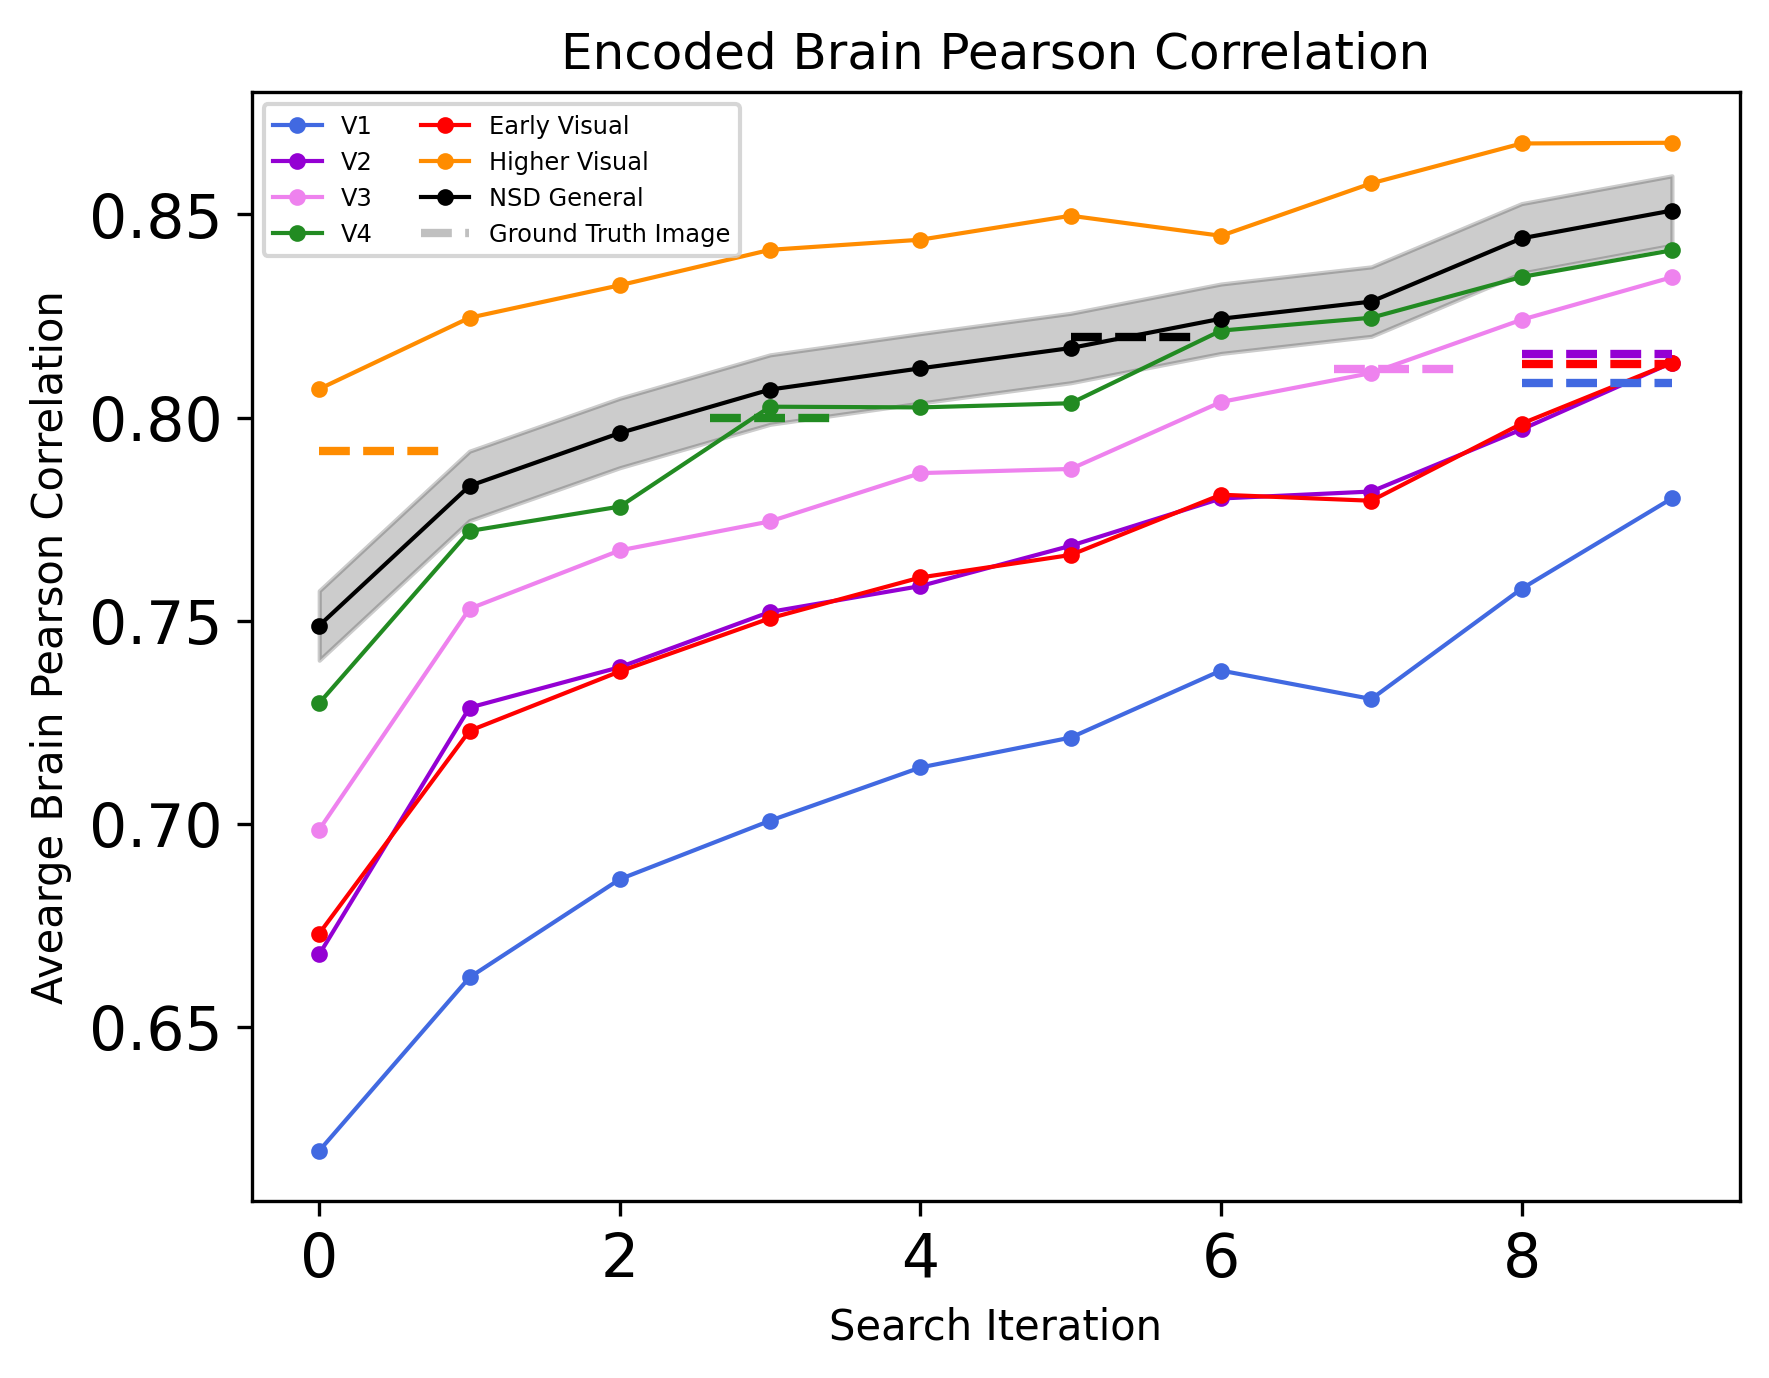

In [26]:
# Average Iteration Brain Region Plot

brain_correlation_V1 = []
brain_correlation_V2 = []
brain_correlation_V3 = []
brain_correlation_V4 = []
brain_correlation_early_visual = []
brain_correlation_higher_visual = []
brain_correlation_unmasked = []
brain_correlation_ground_truth = []

y_v1 = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V1'].mean()
y_v2 = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V2'].mean()
y_v3 = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V3'].mean()
y_v4 = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V4'].mean()
y_ev = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Early Visual'].mean()
y_hv = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Higher Visual'].mean()
y_unmasked = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Unmasked'].mean()

print(y_v2)

v1_set = True
v2_set = True
v3_set = True
v4_set = True
ev_set = True
hv_set = True
unmasked_set = True

x_v1 = 0 
x_v2 = 0 
x_v3 = 0 
x_v4 = 0 
x_ev = 0 
x_hv = 0 
x_umasked = 0 

for iteration in range(10):
    
    iteration_val_v1 = df.loc[(df['Iter'] == iteration)]['Brain Correlation V1'].mean()
    iteration_val_v2 = df.loc[(df['Iter'] == iteration)]['Brain Correlation V2'].mean()
    iteration_val_v3 = df.loc[(df['Iter'] == iteration)]['Brain Correlation V3'].mean()
    iteration_val_v4 = df.loc[(df['Iter'] == iteration)]['Brain Correlation V4'].mean()
    iteration_val_ev = df.loc[(df['Iter'] == iteration)]['Brain Correlation Early Visual'].mean()
    iteration_val_hv = df.loc[(df['Iter'] == iteration)]['Brain Correlation Higher Visual'].mean()
    iteration_val_unmasked = df.loc[(df['Iter'] == iteration)]['Brain Correlation Unmasked'].mean()
    
    brain_correlation_V1.append(iteration_val_v1)
    brain_correlation_V2.append(iteration_val_v2)
    brain_correlation_V3.append(iteration_val_v3)
    brain_correlation_V4.append(iteration_val_v4)
    brain_correlation_early_visual.append(iteration_val_ev)
    brain_correlation_higher_visual.append(iteration_val_hv)
    brain_correlation_unmasked.append(iteration_val_unmasked)
    
    if(iteration_val_v1 > y_v1 and v1_set):
        x_v1 = iteration - 1
        v1_set = False
        
    if(iteration_val_v2 > y_v2 and v2_set):
        x_v2 = iteration - 1
        v2_set = False
        
    if(iteration_val_v3 > y_v3 and v3_set):
        x_v3 = iteration - 1
        v3_set = False
        
    if(iteration_val_v4 > y_v4 and v4_set):
        x_v4 = iteration
        v4_set = False
        
    if(iteration_val_ev > y_ev and ev_set):
        x_ev = iteration - 1
        ev_set = False
        
    if(iteration_val_hv > y_hv and hv_set):
        x_hv = iteration - 1
        hv_set = False
        
    if(iteration_val_unmasked > y_unmasked and unmasked_set):
        x_unmasked = iteration - 1
        unmasked_set = False
    
# print(df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Unmasked'].mean())
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Unmasked'].mean(), linestyle = 'dashed', label = 'Brain Correlation Unmasked')
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V1'].mean(), linestyle = '-', label = 'Brain Correlation V1')
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V2'].mean(), linestyle = '-', label = 'Brain Correlation V2')
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V3'].mean(), linestyle = '-', label = 'Brain Correlation V3')
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V4'].mean(), linestyle = '-', label = 'Brain Correlation V4')
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Higher Visual'].mean(), linestyle = '-', label = 'Brain Correlation Higher Visual')
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Early Visual'].mean(), linestyle = '-', label = 'Brain Correlation Higher Visual')


N = 10
x = np.array([0,1,2,3,4,5,6,7,8,9])
# y = np.array(brain_correlation_unmasked)
# a, b = np.polyfit(x, brain_correlation_unmasked, deg=1)
# y_est = a * x + b
# y_err = st.t.interval(alpha=0.95, df=len(y)-1, loc=np.mean(y), scale=st.sem(y))
# print(y_err[0])
# print(y_err[1])

y_un = np.array(brain_correlation_unmasked)
ci_un = 0.95 * np.std(y_un) / math.sqrt(N)

# y_hi = np.array(brain_correlation_higher_visual)
# ci_hi = 0.95 * np.std(y_hi) / math.sqrt(N)

# y_er = np.array(brain_correlation_early_visual)
# ci_er = 0.95 * np.std(y_er) / math.sqrt(N)

# y_vo = np.array(brain_correlation_V1)
# ci_vo = 0.95 * np.std(y_vo) / math.sqrt(N)

# y_vt = np.array(brain_correlation_V2)
# ci_vt = 0.95 * np.std(y_vt) / math.sqrt(N)

# y_vth = np.array(brain_correlation_V3)
# ci_vth = 0.95 * np.std(y_vth) / math.sqrt(N)

# y_vf = np.array(brain_correlation_V4)
# ci_vf = 0.95 * np.std(y_vf) / math.sqrt(N)

# def mean_confidence_interval(data, confidence=0.95):
#     a = 1.0 * np.array(data)
#     n = len(a)
#     m, se = np.mean(a), scipy.stats.sem(a)
#     h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
#     return m, m-h, m+h

# mean, lower, upper = [],[],[]
# ci = 0.95

# m, ml, mu = mean_confidence_interval(y, ci)
# mean.append(m)
# lower.append(ml)
# upper.append(mu)


plt.plot(brain_correlation_V1, marker='.', label = 'V1', linewidth=1, color = "royalblue")
plt.plot(brain_correlation_V2, marker='.', label = 'V2', linewidth=1, color = "darkviolet")
plt.plot(brain_correlation_V3, marker='.', label = 'V3', linewidth=1, color = "violet")
plt.plot(brain_correlation_V4, marker='.', label = 'V4', linewidth=1, color = "forestgreen")
plt.plot(brain_correlation_early_visual, marker='.', label = 'Early Visual', linewidth=1, color = "red")
plt.plot(brain_correlation_higher_visual, marker='.', label = 'Higher Visual', linewidth=1, color = "darkorange")
plt.plot(brain_correlation_unmasked, marker='.', label = 'NSD General', linewidth=1, color = "black")
# plt.fill_between(x, y_err[0], y_err[0], color='dimgray', alpha=0.2)
# plt.fill_between(x, upper, lower, color='dimgray', alpha=0.2)
plt.fill_between(x, (y_un-ci_un), (y_un+ci_un), color='black', alpha=.2)
# plt.fill_between(x, (y_hi-ci_hi), (y_hi+ci_hi), color='darkorange', alpha=.2)
# plt.fill_between(x, (y_er-ci_er), (y_er+ci_er), color='red', alpha=.2)
# plt.fill_between(x, (y_vo-ci_vo), (y_vo+ci_vo), color='royalblue', alpha=.2)
# plt.fill_between(x, (y_vt-ci_vt), (y_vt+ci_vt), color='darkviolet', alpha=.2)
# plt.fill_between(x, (y_vth-ci_vth), (y_vth+ci_vth), color='violet', alpha=.2)
# plt.fill_between(x, (y_vf-ci_vf), (y_vf+ci_vf), color='forestgreen', alpha=.2)

plt.plot([8, 8 + 1], [y_v1, y_v1] , color = "royalblue", linestyle="dashed", linewidth=2)
plt.plot([8, 8 + 1], [y_v2, y_v2] , color = "darkviolet", linestyle="dashed", linewidth=2)
plt.plot([x_v3-0.25, x_v3 + 0.55], [y_v3, y_v3] , color = "violet", linestyle="dashed", linewidth=2)
plt.plot([x_v4 - 0.40, x_v4 + 0.4], [y_v4- 0.002, y_v4- 0.002] , color = 'forestgreen', linestyle="dashed", linewidth=2)
plt.plot([8, 8 + 1], [y_ev - 0.002, y_ev - 0.002] , color = 'red', linestyle="dashed", linewidth=2)
plt.plot([0, 0 + 0.85], [y_hv, y_hv] , color = "darkorange", linestyle="dashed", linewidth=2)
plt.plot([x_unmasked, x_unmasked + 0.85], [y_unmasked, y_unmasked] , color = 'black', linestyle="dashed", linewidth=2, label="Ground Truth Image")
#plt.axhline(x = [1,3], y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Unmasked'].mean(), linestyle = 'dashed', label = 'Brain Correlation Unmasked')
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V1'].mean(), linestyle = '-', label = 'Brain Correlation V1')
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V2'].mean(), linestyle = '-', label = 'Brain Correlation V2')
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V3'].mean(), linestyle = '-', label = 'Brain Correlation V3')
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation V4'].mean(), linestyle = '-', label = 'Brain Correlation V4')
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Higher Visual'].mean(), linestyle = '-', label = 'Brain Correlation Higher Visual')
# plt.axhline(y = df.loc[(df['Sample Indicator'] == 0.0)]['Brain Correlation Early Visual'].mean(), linestyle = '-', label = 'Brain Correlation Higher Visual')
leg = plt.legend(loc="upper left", ncol = 2, fontsize = "xx-small")
leg.legendHandles[7].set_color('silver')
plt.xlabel("Search Iteration")
plt.ylabel("Avearge Brain Pearson Correlation")
plt.title("Encoded Brain Pearson Correlation")
mpl.rcParams['figure.dpi'] = 300


0


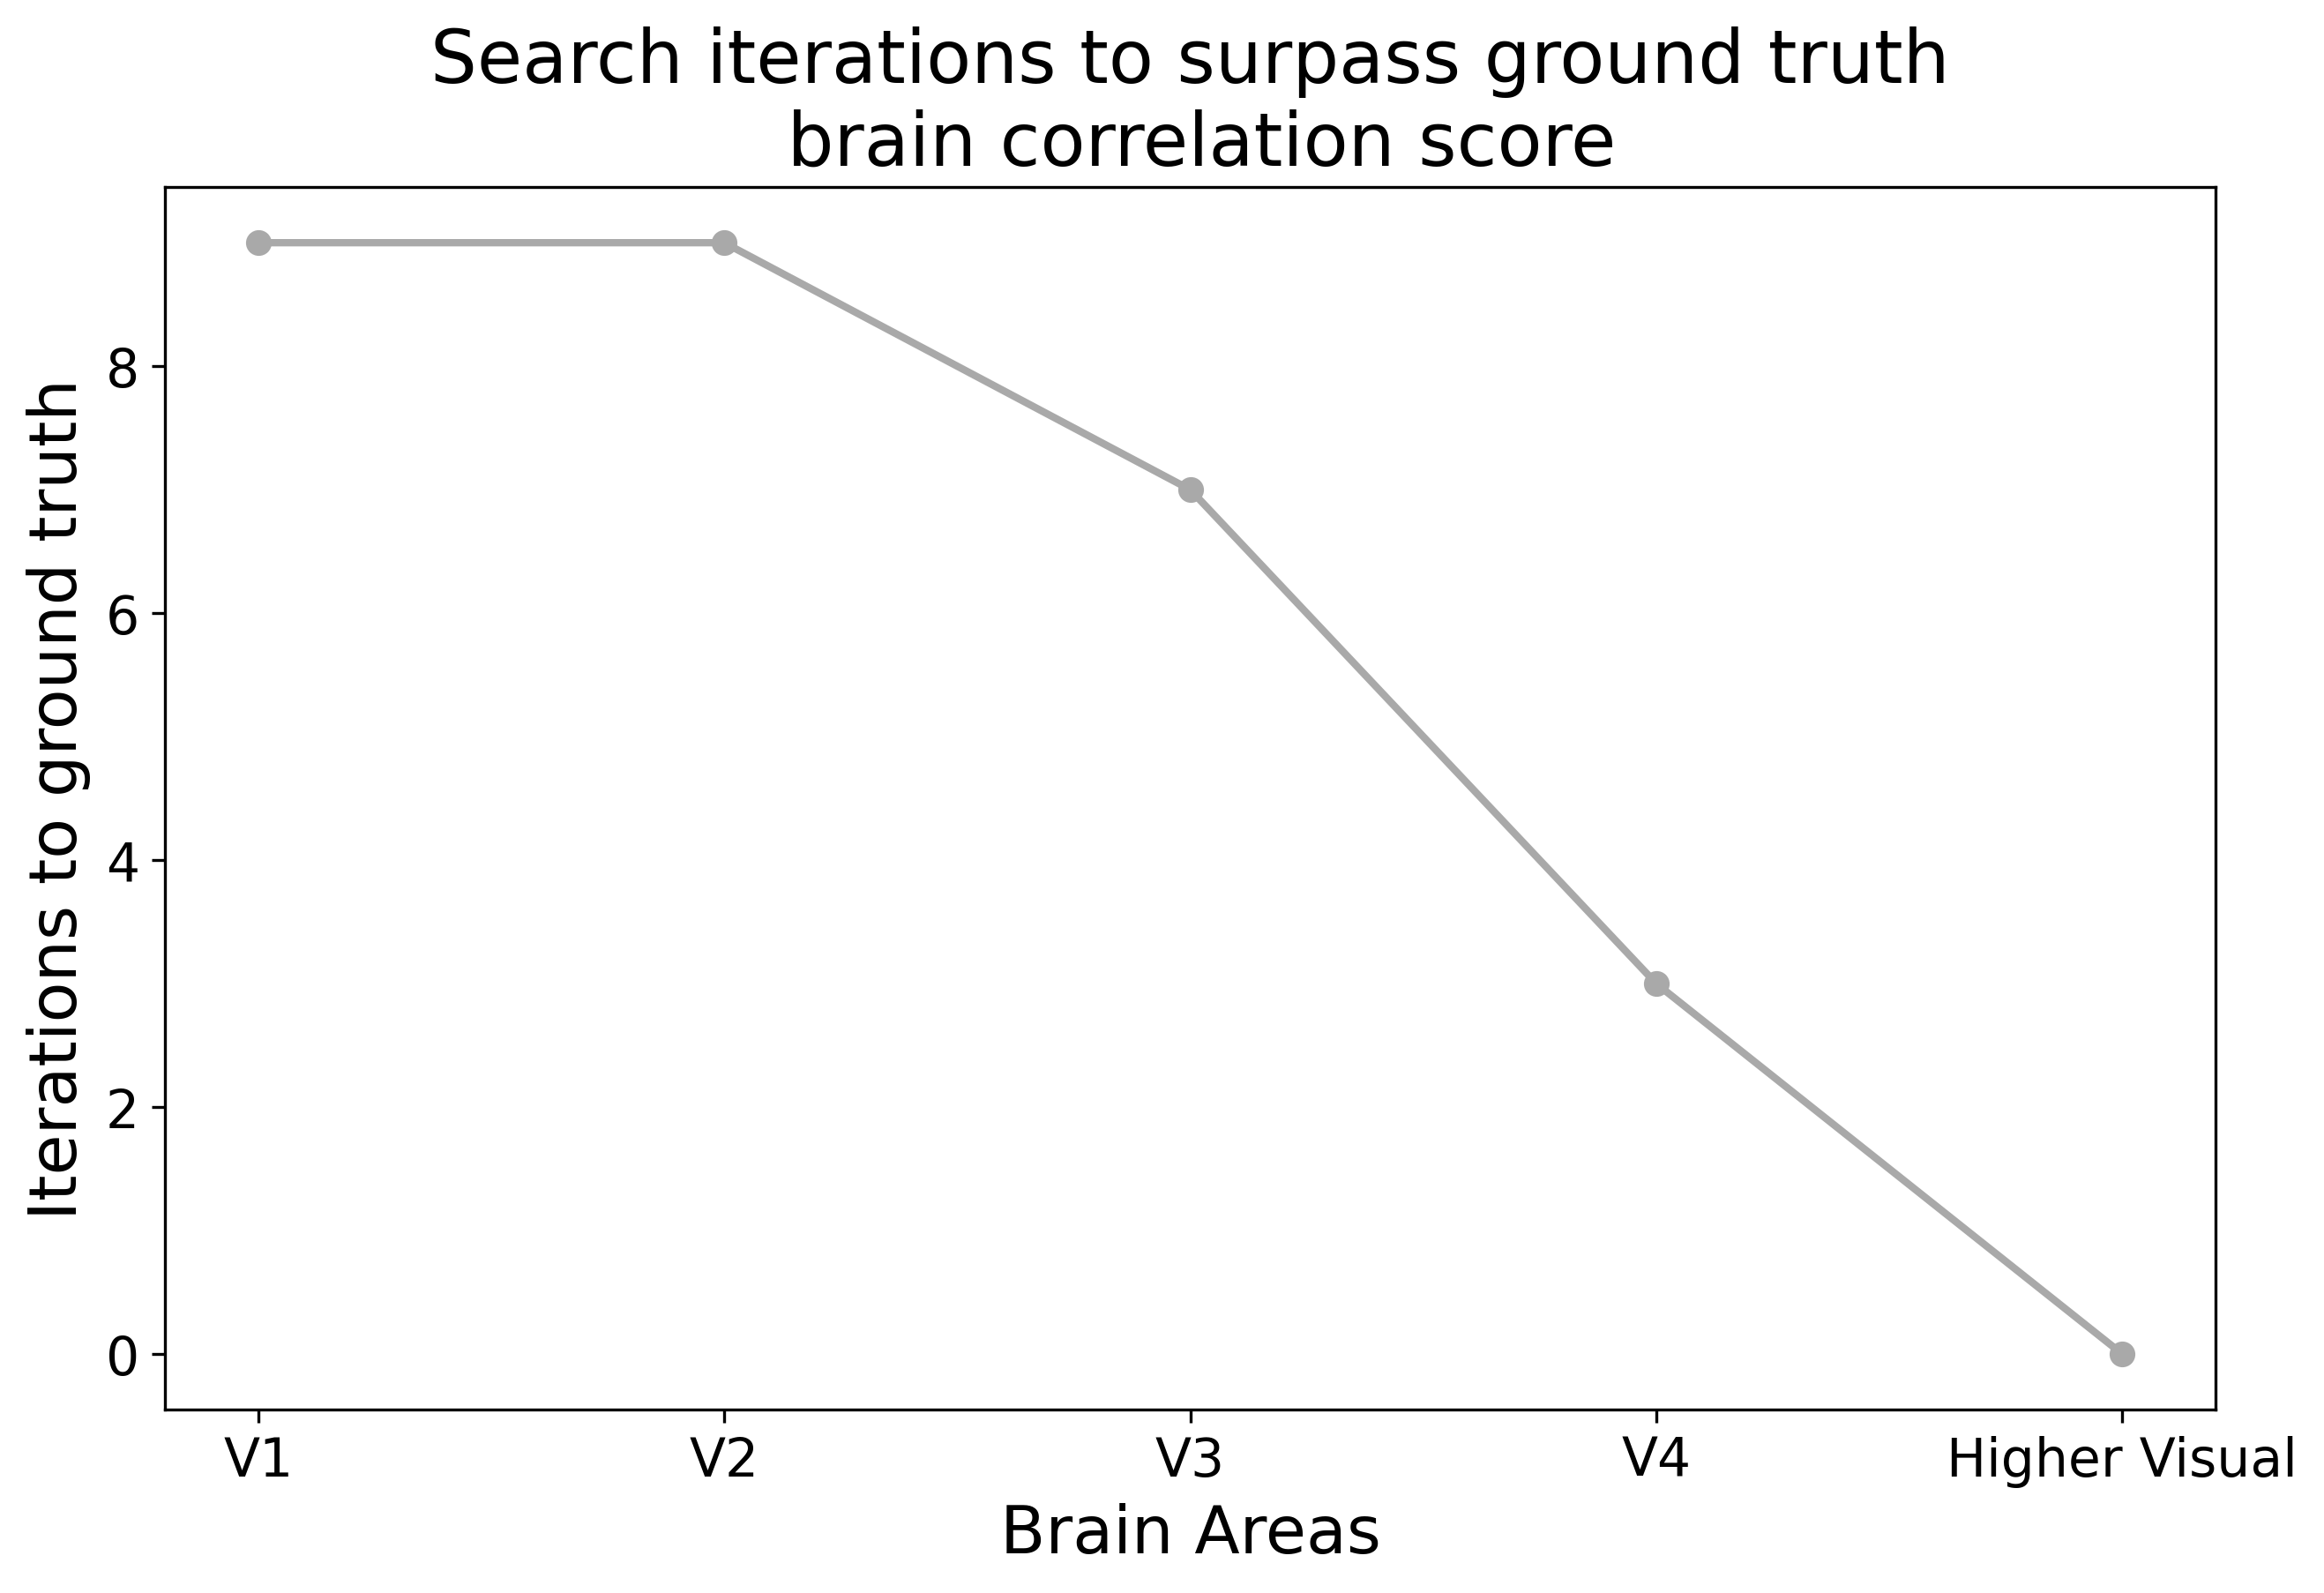

In [28]:
# Search iterations to Ground Truth

x_iter_values = []

print(x_v2)

x_iter_values.append(9)
x_iter_values.append(9)
x_iter_values.append(x_v3)
x_iter_values.append(x_v4)
x_iter_values.append(0)

x_labels = ['V1', 'V2', 'V3', 'V4', 'Higher Visual']

# x_iter_values.append(0)
# x_iter_values.append(x_v4)
# x_iter_values.append(x_v3)
# x_iter_values.append(x_v2)
# x_iter_values.append(9)

# x_labels = ['Higher Visual', 'V4', 'V3', 'V2', 'V1']

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(x_labels, x_iter_values, marker='o', linewidth=2, color = "darkgray")

plt.xlabel("Brain Areas", fontsize=18)
plt.ylabel("Iterations to ground truth", fontsize=18)
plt.title("Search iterations to surpass ground truth\n brain correlation score", fontsize=20)
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['ytick.labelsize'] = 'x-large'

Text(0.5, 1.0, 'Encoded Brain Pearson Correlation Unmasked')

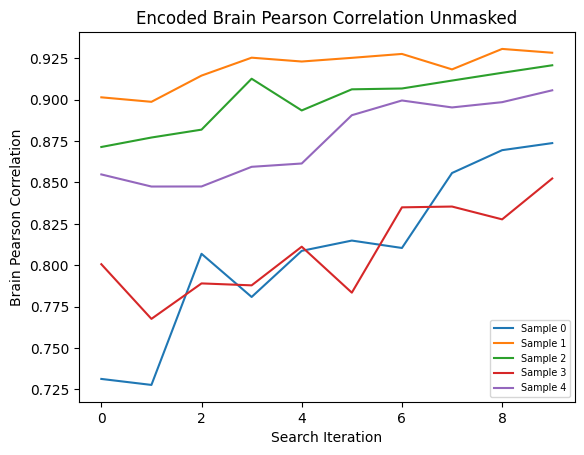

In [14]:
# Single Iteration Brain Region Plot

sample_0 = []
sample_1 = []
sample_2 = []
sample_3 = []
sample_4 = []
sample_5 = []
sample_6 = []
sample_7 = []
sample_8 = []
sample_9 = []

for iteration in range(10):
    sample_0.append(df.loc[(df['Iter'] == iteration) & (df['ID'] == 0)]['Brain Correlation Unmasked'])
    sample_1.append(df.loc[(df['Iter'] == iteration) & (df['ID'] == 1)]['Brain Correlation Unmasked'])
    sample_2.append(df.loc[(df['Iter'] == iteration) & (df['ID'] == 2)]['Brain Correlation Unmasked'])
    sample_3.append(df.loc[(df['Iter'] == iteration) & (df['ID'] == 3)]['Brain Correlation Unmasked'])
    sample_4.append(df.loc[(df['Iter'] == iteration) & (df['ID'] == 4)]['Brain Correlation Unmasked'])
    sample_5.append(df.loc[(df['Iter'] == iteration) & (df['ID'] == 5)]['Brain Correlation Unmasked'])
    sample_6.append(df.loc[(df['Iter'] == iteration) & (df['ID'] == 6)]['Brain Correlation Unmasked'])
    sample_7.append(df.loc[(df['Iter'] == iteration) & (df['ID'] == 7)]['Brain Correlation Unmasked'])
    sample_8.append(df.loc[(df['Iter'] == iteration) & (df['ID'] == 8)]['Brain Correlation Unmasked'])
    sample_9.append(df.loc[(df['Iter'] == iteration) & (df['ID'] == 9)]['Brain Correlation Unmasked'])


plt.plot(sample_0, label = 'Sample 0')
plt.plot(sample_1, label = 'Sample 1')
plt.plot(sample_2, label = 'Sample 2')
plt.plot(sample_3, label = 'Sample 3')
plt.plot(sample_4, label = 'Sample 4')
plt.plot(sample_5, label = 'Sample 5')
plt.plot(sample_6, label = 'Sample 6')
plt.plot(sample_7, label = 'Sample 7')
plt.plot(sample_8, label = 'Sample 8')
plt.plot(sample_9, label = 'Sample 9')
plt.legend(fontsize = "x-small")
plt.xlabel("Search Iteration")
plt.ylabel("Brain Pearson Correlation")
plt.title("Encoded Brain Pearson Correlation Unmasked")